# 第21章 PageRank算法    
    
    21.1 PageRank 的定义    
        21.1.1 基本想法    
        21.1.2 有向图和随机游走模型    
        21.1.3 PageRank 的基本定义    
        21.1.4 PageRank 的一般定义    
    21.2 PageRank 的计算    
        21.2.1 迭代算法    
        21.2.2 幂法    
        21.3.3 代数算法   
        
在实际应用中许多数据都以图（graph）的形式存在，比如，互联网、社交网络都可以看作是一个图。
图数据上的机器学习具有理论与应用上的重要意义。
PageRank算法是图的链接分析（link analysis）的代表性算法，属于图数据上的无监督学习方法。

PageRank算法最初作为互联网网页重要度的计算方法，1996年由Page和Brin提出，并用于谷歌搜索引擎的网页排序。
事实上，PageRank可以定义在任意有向图上，后来被应用到社会影响力分析、文本摘要等多个问题。

PageRank算法的基本想法是在有向图上定义一个随机游走模型，即一阶马尔可夫链，描述随机游走者沿着有向图随机访问各个结点的行为。
在一定条件下，极限情况访问每个结点的概率收敛到平稳分布，这时各个结点的平稳概率值就是其PageRank值，表示结点的重要度。
PageRank是递归定义的，PageRank的计算可以通过迭代算法进行。
        

In [26]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## 21.1 PageRank 的定义    

###     21.1.1 基本想法    

历史上，PageRank算法作为计算互联网网页重要度的算法被提出。
PageRank是定义在网页集合上的一个函数，它对每个网页给出一个正实数，表示网页的重要程度，整体构成一个向量，PageRank值越高，网页就越重要，在互联网搜索的排序中可能就被排在前面。

网页在搜索引擎上的排序，除了网页本身的要度以外，还由网页与查询的匹配度决定。
在互联网搜索中，网页的PageRank与查询无关，可以事先离线计算，加入网页索引。

假设互联网足一个有向图，在其基础上定义随机游走模型，即一阶马尔可夫链，表示网页浏览者在互联网上随机浏览网页的过程。
假设浏览者在每个网页依照连接出去的超链接以等概率跳转到下一个网页，并在网上持续不断进行这样的随机跳转，这个过程形成一阶马尔可夫链。
PageRank表示这个马尔可夫链的平稳分布。
每个网页的PageRank值就是平稳概率。

下图是一个有向图，假设是简化的互联网例，结点 $A,B,C,D$ 表示网页，结点之间的有向边表示网页之间的超链接，边上的权值表示网页之间随机跳转的概率。
假设有一个浏览者，在网上随机游走。
1. 如果浏览者在网页 $A$，则下一步以 $1/3$ 的概率转移到网页 $B,C, D$。
2. 如果浏览者在网页 $B$，则下一步以 $1/2$ 的概率转移到网页 $A$ 和 $D$。
3. 如果浏览者在网页 $C$，则下一步以概率 $1$ 转移到网页 $A$。
4. 如果浏览者在网页 $D$，则下一步以 $1/2$ 的概率转移到网页 $B$ 和 $C$ 。

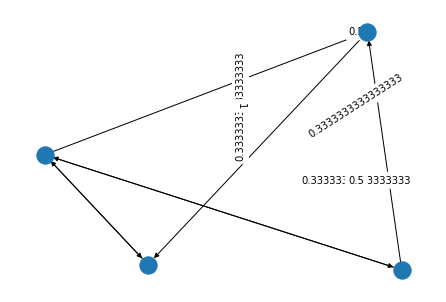

In [25]:
g = nx.DiGraph(name="Example")
g.clear() #将图上元素清空

node_list = [
    ("A", (0, 0)),
    ("B", (0, 1)),
    ("C", (1, 0)),
    ("D", (1, 1)),
]

g.add_node("A",pos=(0,0))
g.add_node("B",pos=(1,0))
g.add_node("C",pos=(0,1))
g.add_node("D",pos=(1,1))

weight_edges = [
    ("A", "B", 1/3),
    ("A", "C", 1/3),
    ("A", "D", 1/3),
    ("B", "A", 1/2),
    ("B", "D", 1/2),
    ("C", "A", 1),
    ("D", "C", 1/2),   
]

g.add_weighted_edges_from(weight_edges)
nx.draw(g)
labels = nx.get_edge_attributes(g,'weight')
pos=nx.get_node_attributes(g,'pos')
nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)
plt.show()


直观上，一个网页，如果指向该网页的超链接越多，随机跳转到该网页的概率也就越高，该网页的PageRank值就越高，这个网页也就越重要。
一个网页，如果指向该网页的PageRank值越高，随机跳转到该网页的概率也就越高，该网页的PageRank值就越高，这个网页也就越重要。
PageRank值依赖于网络的拓扑结构，一旦网络的拓扑（连接关系）确定，PageRank值就确定。

PageRank的计算可以在互联网的有向图上进行，通常是一个迭代过程。
先假设一个初始分布，通过迭代，不断计算所有网页的PageRank值，直到收敛为止。

###     21.1.2 有向图和随机游走模型

**定义**

*有向图（directed graph）记作 $G=(V,E)$，其中 $V$ 和 $E$ 分别表示结点和有向边的集合。*

比如，互联网就可以看作是一个有向图，每个网页是有向图的一个结点，网页之间的每一条超链接是有向图的一条边。
从一个结点出发到达另一个结点，所经过的边的一个序列称为一条路径（path），路径上边的个数称为路径的长度。
如果一个有向图从其中任何一个结点出发可以到达其他任何一个结点，就称这个有向图是强连通图（strongly connected graph）。

假设是一个大于1的自然数，如果从有向图的一个结点出发返冋到这个结点的路径的长度都是 $k$ 的倍数，那么称这个结点为周期性结点。
如果一个有向图不含有周期性结点，则称这个有向图为非周期性图（aperiodic graph），否则为周期性图。

**定义**

给定一个含有 $n$ 个结点的有向图，在有向图上定义*随机游走*（random walk）模型，即一阶马尔可夫链，其中结点表示状态，有向边表示状态之间的转移，假设从一个结点到通过有向边相连的所有结点的转移概率相等。
具体地，转移矩阵是一个 $n$ 阶矩阵 $M$

$$ M = [m_{ij}]_{nxn}$$

第 $i$ 行第 $j$ 列的元素取值规则如下：
如果结点 $j$ 有 $k$ 个有向边连出，并且结点 $i$ 是其连出的一个结点，则 $m_{ij}=\frac{1}{k}$
否则 $m_{ij}=0, i,j = 1,2,\cdots,n$。

注意转移矩阵每个元素非负，每列元素之和为 $1$，即矩阵 $M$ 为随机矩阵（stochastic matrix）。

在有向图上的随机游走形成马尔可夫链。
也就是说，随机游走者每经一个单位时间转移一个状态，如果当前时刻在第 $j$ 个结点（状态），那么下一个时刻在第 $i$ 个结点（状态）的概率是 $m_{ij}$，这一概率只依赖于当前的状态，与过去无关，具有马尔可夫性。

随机游走在某个时刻 $t$ 访问各个结点的概率分布就是马尔可夫链在时刻 $t$ 的状态分布，可以用一个 $n$ 维列向量 $R_t$ 表示，那么在时刻 $t+1$ 访问各个结点的概率分布 $R_{t+1}$ 满足

$$R_{t+1} = MR_t $$

###     21.1.3 PageRank 的基本定义


###     21.1.4 PageRank 的一般定义    

## 21.2 PageRank 的计算    

###     21.2.1 迭代算法    

输入：含有 $n$ 个结点的有向图，转移矩阵 $M$，阻尼因子 $d$，初始向量 $R_0$；

输出：有向图的PageRank向量 $R$。

1. 令 $t=0$
2. 计算 
$$ R_{t+1} = d M R_t + \frac{1-d}{n}l$$
3. 如果 $R_{t+1}$ 与 $R_t$ 充分接近，令 $R=R_{t+1}$，停止迭代。
4. 否则，令 $t=t+1$，执行步（2)。 

In [29]:
def page_rank(trans_mat, d=0.8):
    (n, m) = trans_mat.shape
    assert n == m
    
    dm = d * trans_mat
    dl = ((1-d)/n) * np.ones([n]).T
    
    R = (1/n) * np.ones([n]).T

    while True:
        R_new = np.matmul(dm, R) + dl
        
        if np.allclose(R, R_new):
            return R
        else:
            R = R_new

In [31]:
M = np.array([
    [0, 1/2, 0, 0],
    [1/3, 0, 0, 1/2],
    [1/3, 0, 1, 1/2],
    [1/3, 1/2, 0, 0]
])

r = page_rank(M, 0.8)
print(r)

[0.10135339 0.12838135 0.64188392 0.12838135]


###     21.2.2 幂法    

###     21.3.3 代数算法   
